In [36]:
import numpy as np
from numpy.linalg import det

In [2]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [1]:
def R(theta):
    """Rotation matrix.
    Input:
      - theta: angle in degrees
    """
    theta_rad = np.deg2rad(theta)
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    return np.array([[c, -s], [s, c]])

In [2]:
def get_sigma(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additional_error=0.6):
    """
    Get the covariance matrix between an elongated 
    radio source and an optical source.
    
    Input:
    * maj_error: error in the major axis of the radio Gaussian in arsecs
    * min_error: error in the minor axis of the radio Gaussian in arsecs
    * pos_angle: position angle of the radio Gaussian in degrees
    * radio_ra: Right ascension of the radio source in degrees
    * radio_dec: Declination of the radio source in degrees
    * opt_ra: Right ascension of the optical source in degrees
    * opt_dec: Declination of the optical source in degrees
    * opt_ra_err: Error in right ascension of the optical source in degrees
    * opt_dec_err: Error in declination of the optical source in degrees
    * additonal_error: Additonal term to add to the error. By default
        it adds an astrometic error of 0.6 arcsecs.
    
    Output:
    * sigma: Combined covariance matrix
    """
    factor = 0.60056120439322491 # sqrt(2.0) / sqrt(8.0 * log(2)); see Condon(1997) for derivation of adjustment factor
    majerr = factor * maj_error
    minerr = factor * min_error
    # angle between the radio and the optical sources
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2((opt_dec - radio_dec), ((opt_ra - radio_ra)*cosadj))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    alpha = np.pi/2.0 - phi - np.deg2rad(pos_angle) 
    # Covariance matrices
    sigma_radio_nr = np.array([[majerr**2, 0], [0, minerr**2]])
    sigma_optical_nr = np.array([[opt_ra_err**2, 0], [0, opt_dec_err**2]])
    # Rotate the covariance matrices
    R_radio = R(alpha)
    sigma_radio = R_radio @ sigma_radio_nr @ R_radio.T
    R_optical = R(-phi)
    sigma_optical = R_optical @ sigma_optical_nr @ R_optical.T
    # Additional error
    sigma_additonal_error = np.array([[additional_error**2, 0], [0, additional_error**2]])
    sigma = sigma_radio + sigma_optical + sigma_additonal_error
    return sigma

In [3]:
def get_sigma_all(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additional_error=0.6):
    """Apply the get_sigma function in parallel and return the determinant of 
    the covariance matrix and its [1,1] term (or [0,0] in Python)
    """
    n = len(opt_ra)
    det_sigma = np.empty(n)
    sigma_0_0 = np.empty(n)
    for i in range(n):
        sigma = get_sigma(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra[i], opt_dec[i], opt_ra_err[i], opt_dec_err[i], 
              additional_error=additional_error)
        det_sigma[i] = det(sigma)
        sigma_0_0[i] = sigma[0,0]
    return sigma_0_0, det_sigma

In [4]:
def get_sigma_all_old(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additonal_error=0.6):
    """
    Get the combined error and the axes components between an elongated 
    radio source and an optical source.
    
    Input:
    * maj_error: error in the major axis of the radio Gaussian in arsecs
    * min_error: error in the minor axis of the radio Gaussian in arsecs
    * pos_angle: position angle of the radio Gaussian in degrees
    * radio_ra: Right ascension of the radio source in degrees
    * radio_dec: Declination of the radio source in degrees
    * opt_ra: Right ascension of the optical source in degrees
    * opt_dec: Declination of the optical source in degrees
    * opt_ra_err: Error in right ascension of the optical source in degrees
    * opt_dec_err: Error in declination of the optical source in degrees
    * additonal_error: Additonal term to add to the error. By default
        it adds an astrometic error of 0.6 arcsecs.
    
    Output:
    * sigma: Combined error
    * sigma_maj: Error in the major axis direction
    * sigma_min: Error in the minor axis direction
    """
    factor = 0.60056120439322491 # sqrt(2.0) / sqrt(8.0 * log(2)); see Condon(1997) for derivation of adjustment factor
    majerr = factor * maj_error
    minerr = factor * min_error
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2((opt_dec - radio_dec), ((opt_ra - radio_ra)*cosadj))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    sigma = np.pi/2.0 - phi - np.deg2rad(pos_angle) 
    
    maj_squared = ((majerr * np.cos(sigma))**2 + 
                   (opt_ra_err * np.cos(phi))**2 +
                   additonal_error**2/2.
                   )
    min_squared = ((minerr * np.sin(sigma))**2 + 
                   (opt_dec_err * np.sin(phi))**2 +
                   additonal_error**2/2.
                   )
    return np.sqrt(maj_squared + min_squared), np.sqrt(maj_squared), np.sqrt(min_squared)

In [5]:
def compare_sigma(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additional_error=0.6):
    factor = 0.60056120439322491 # sqrt(2.0) / sqrt(8.0 * log(2)); see Condon(1997) for derivation of adjustment factor
    majerr = factor * maj_error
    minerr = factor * min_error
    # angle between the radio and the optical sources
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2((opt_dec - radio_dec), ((opt_ra - radio_ra)*cosadj))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    alpha = np.pi/2.0 - phi - np.deg2rad(pos_angle) 
    
    # Old
    maj_squared = ((majerr * np.cos(alpha))**2 + 
                   (opt_ra_err * np.cos(phi))**2 +
                   additional_error**2/2.
                   )
    min_squared = ((minerr * np.sin(alpha))**2 + 
                   (opt_dec_err * np.sin(phi))**2 +
                   additional_error**2/2.
                   )
    # Covariance matrices
    sigma_radio_nr = np.array([[majerr**2, 0], [0, minerr**2]])
    sigma_optical_nr = np.array([[opt_ra_err**2, 0], [0, opt_dec_err**2]])
    # Rotate the covariance matrices
    R_radio = R(alpha)
    sigma_radio = R_radio @ sigma_radio_nr @ R_radio.T
    R_optical = R(-phi)
    sigma_optical = R_optical @ sigma_optical_nr @ R_optical.T
    # Additional error
    sigma_additonal_error = np.array([[additional_error**2, 0], [0, additional_error**2]])
    sigma = sigma_radio + sigma_optical + sigma_additonal_error
    print(np.sqrt(maj_squared + min_squared), np.sqrt(maj_squared), np.sqrt(min_squared))
    print(sigma, det(sigma), sigma[0,0])    

In [6]:
compare_sigma(2.1946708811720677, 0.4100846697008271, 50.06371279231633, 185.15272884697757, 50.50747173493889,
              185.14997539, 50.51034594, 0.04323999956250191, 0.05682000145316124)

NameError: name 'np' is not defined

In [2]:
from matplotlib import pyplot as plt


NameError: name 'patches' is not defined

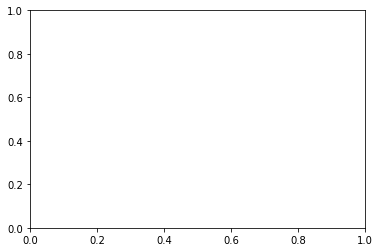

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='auto')
e1 = patches.Ellipse((185.15272884697757, 50.50747173493889), 
                     2.1946708811720677/3600., 0.4100846697008271/3600.,
                     angle=np.deg2rad(50.06371279231633), linewidth=2, fill=False, zorder=2)
e2 = patches.Ellipse((185.14997539, 50.51034594), 
                     0.04323999956250191/3600., 0.05682000145316124/3600.,
                     angle=np.deg2rad(0.), linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)
ax.add_patch(e2)

In [ ]:
10619585 8.146669821114509 6.205941702040493e-07
10619584 11.165577527224745 6.205941702040493e-07
[2.09247864 2.12776272 2.09805469] 
[0.88298441 0.96200201 0.88976522] 
[2.08069841e-14 2.78922734e-08 1.14443646e-16] 
[1.44815998 0.80857455 0.67887615] 
[1.38456969 0.64243816 0.46820454] 
[0.42442206 0.49098473 0.49158655] 
[3.34175321e-14 4.56806505e-23 4.69443288e-70]
(lofar_maj_err, lofar_min_err, lofar_pa, 
        lofar_ra, lofar_dec, c_ra, c_dec, c_ra_err, c_dec_err)
(2.1946708811720677, 0.4100846697008271, 50.06371279231633, 185.15272884697757, 50.50747173493889, <MaskedColumn name='ra' dtype='float64' length=3>
185.14894305
185.15581771
185.14997539, <MaskedColumn name='dec' dtype='float64' length=3>
50.50551663
50.50634841
50.51034594, <MaskedColumn name='raErr' dtype='float64' length=3>
0.01865999959409237
 0.1769299954175949
0.04323999956250191, <MaskedColumn name='decErr' dtype='float64' length=3>
0.017410000786185265
  0.1769299954175949
 0.05682000145316124)

## Main individual tests

In [5]:
import numpy as np

Test the computation of the angle between the two sources

In [18]:
def compute_phi(radio_ra, radio_dec, opt_ra, opt_dec):
    """Compute the angle (in radians) between two sources
    """
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2(((opt_ra - radio_ra)*cosadj), (opt_dec - radio_dec))
    return phi

In [19]:
test_positions = [
    ([2, 2, 1, 3], -45),
    ([2, 2, 2, 3], 0),
    ([2, 2, 3, 3], 45),
    ([2, 2, 1, 2], -90),
    ([2, 2, 3, 2], 90),
    ([2, 2, 1, 1], -135),
    ([2, 2, 2, 1], 180),
    ([2, 2, 3, 1], 135)
]

In [20]:
for pos, angle in test_positions:
    print(np.rad2deg(compute_phi(*pos)), angle)

-44.97272057688162 -45
0.0 0
44.97272057688162 45
-90.0 -90
90.0 90
-135.00981859852072 -135
180.0 180
135.00981859852072 135


Test the computation of alpha, the angle between the radio major axis and the line

In [ ]:
alpha = np.pi/2.0 - phi - np.deg2rad(pos_angle) 

In [21]:
test_angles = [
    ((-45, -45), 0),
    ((-45, 0), 45),
    ((-45, -90), -45),
    ((90, 0), -90),
    ((90, 90), 0),
    ((90, 135), 45),
]

In [23]:
for fpa, alpha in test_angles:
    alpha_comp = np.rad2deg(np.pi/2.0 - np.deg2rad(fpa[0]) - np.deg2rad(fpa[1])) # Old angles
    print(alpha_comp, alpha)

180.0 0
135.0 45
225.0 -45
0.0 -90
-90.0 0
-135.0 45


In [27]:
for fpa, alpha in test_angles:
    alpha_comp = -np.rad2deg(np.deg2rad(fpa[0]) - np.deg2rad(fpa[1])) # Corrected
    print(alpha_comp, alpha)

-0.0 0
45.0 45
-45.0 -45
-90.0 -90
-0.0 0
45.0 45


Test the rotation of the radio covariance

In [29]:
test_sigma_rotation_radio = [
    (([[2,0],[0,0.5]], 0), 2),
    (([[2,0],[0,0.5]], -90), 0.5)
]

In [30]:
for params, maj_e in test_sigma_rotation_radio:
    Rot = R(params[1])
    sigma_rot = Rot @ params[0] @ Rot.T
    print(sigma_rot[0,0], maj_e)

2.0 2
0.5 0.5


Test the rotation of the optical Covariance

In [31]:
test_sigma_rotation_optical = [
    (([[2,0],[0,0.5]], -45), 1),
    (([[2,0],[0,0.5]], 45), 1),
    (([[2,0],[0,0.5]], 0), 2),
    (([[2,0],[0,0.5]], -90), 0.5),
    (([[0.5,0],[0,2]], -45), 1),
    (([[0.5,0],[0,2]], 45), 1),
    (([[0.5,0],[0,2]], 0), 0.5),
    (([[0.5,0],[0,2]], -90), 2),
]

In [32]:
for params, maj_e in test_sigma_rotation_optical:
    Rot = R(params[1])
    sigma_rot = Rot @ params[0] @ Rot.T
    print(sigma_rot[0,0], maj_e)

1.2500000000000002 1
1.2500000000000002 1
2.0 2
0.5 0.5
1.2499999999999998 1
1.2499999999999998 1
0.5 0.5
2.0 2


Compare the new implementation and the old one

In [39]:
def compare_sigma_new(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additional_error=0.6):
    factor = 0.60056120439322491 # sqrt(2.0) / sqrt(8.0 * log(2)); see Condon(1997) for derivation of adjustment factor
    majerr = factor * maj_error
    minerr = factor * min_error
    # angle between the radio and the optical sources
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2(((opt_ra - radio_ra)*cosadj), (opt_dec - radio_dec))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    alpha = -(np.deg2rad(phi) - np.deg2rad(pos_angle))
    
    # Old
    phi2 = np.arctan2((opt_dec - radio_dec), ((opt_ra - radio_ra)*cosadj))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    sigma2 = np.pi/2.0 - phi2 - np.deg2rad(pos_angle) 
    
    maj_squared = ((majerr * np.cos(sigma2))**2 + 
                   (opt_ra_err * np.cos(phi2))**2 +
                   additional_error**2/2.
                   )
    min_squared = ((minerr * np.sin(sigma2))**2 + 
                   (opt_dec_err * np.sin(phi2))**2 +
                   additional_error**2/2.
                   )
    # Covariance matrices
    sigma_radio_nr = np.array([[majerr**2, 0], [0, minerr**2]])
    sigma_optical_nr = np.array([[opt_dec_err**2, 0], [0, opt_ra_err**2]])
    # Rotate the covariance matrices
    R_radio = R(alpha)
    sigma_radio = R_radio @ sigma_radio_nr @ R_radio.T
    R_optical = R(phi)
    sigma_optical = R_optical @ sigma_optical_nr @ R_optical.T
    # Additional error
    sigma_additonal_error = np.array([[additional_error**2, 0], [0, additional_error**2]])
    sigma = sigma_radio + sigma_optical + sigma_additonal_error
    print(np.sqrt(maj_squared + min_squared), np.sqrt(maj_squared), np.sqrt(min_squared))
    print(sigma, det(sigma), sigma[0,0]) 

In [40]:
compare_sigma_new(2.1946708811720677, 0.4100846697008271, 50.06371279231633, 185.15272884697757, 50.50747173493889,
              185.14997539, 50.51034594, 0.04323999956250191, 0.05682000145316124)

0.6788761491234668 0.46820453743047535 0.4915865508516503
[[2.10004405 0.02583039]
 [0.02583039 0.42292258]] 0.8874888436809194 2.100044050730553


In [41]:
def compare_sigma_new_implementations(maj_error, min_error, pos_angle, 
              radio_ra, radio_dec, 
              opt_ra, opt_dec, opt_ra_err, opt_dec_err, 
              additional_error=0.6):
    factor = 0.60056120439322491 # sqrt(2.0) / sqrt(8.0 * log(2)); see Condon(1997) for derivation of adjustment factor
    majerr = factor * maj_error
    minerr = factor * min_error
    # angle between the radio and the optical sources
    cosadj = np.cos(np.deg2rad(0.5*(radio_dec + opt_dec)))
    phi = np.arctan2(((opt_ra - radio_ra)*cosadj), (opt_dec - radio_dec))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    alpha = -(np.deg2rad(phi) - np.deg2rad(pos_angle))
    
    # Covariance matrices
    sigma_radio_nr = np.array([[majerr**2, 0], [0, minerr**2]])
    sigma_optical_nr = np.array([[opt_dec_err**2, 0], [0, opt_ra_err**2]])
    # Rotate the covariance matrices
    R_radio = R(alpha)
    sigma_radio = R_radio @ sigma_radio_nr @ R_radio.T
    R_optical = R(phi)
    sigma_optical = R_optical @ sigma_optical_nr @ R_optical.T
    # Additional error
    sigma_additonal_error = np.array([[additional_error**2, 0], [0, additional_error**2]])
    sigma = sigma_radio + sigma_optical + sigma_additonal_error
    print(sigma, det(sigma), sigma[0,0])
    #### Previous new implementation
    phi = np.arctan2((opt_dec - radio_dec), ((opt_ra - radio_ra)*cosadj))
    # angle from direction of major axis to vector joining LOFAR source and optical source
    alpha = np.pi/2.0 - phi - np.deg2rad(pos_angle) 
    # Covariance matrices
    sigma_radio_nr = np.array([[majerr**2, 0], [0, minerr**2]])
    sigma_optical_nr = np.array([[opt_ra_err**2, 0], [0, opt_dec_err**2]])
    # Rotate the covariance matrices
    R_radio = R(alpha)
    sigma_radio = R_radio @ sigma_radio_nr @ R_radio.T
    R_optical = R(-phi)
    sigma_optical = R_optical @ sigma_optical_nr @ R_optical.T
    # Additional error
    sigma_additonal_error = np.array([[additional_error**2, 0], [0, additional_error**2]])
    sigma = sigma_radio + sigma_optical + sigma_additonal_error
    print(sigma, det(sigma), sigma[0,0])

In [42]:
compare_sigma_new_implementations(2.1946708811720677, 0.4100846697008271, 50.06371279231633, 185.15272884697757, 50.50747173493889,
              185.14997539, 50.51034594, 0.04323999956250191, 0.05682000145316124)

[[2.10004405 0.02583039]
 [0.02583039 0.42292258]] 0.8874888436809194 2.100044050730553
[[ 2.09805469 -0.04151227]
 [-0.04151227  0.42491194]] 0.8897652213771526 2.0980546927451607
